In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
import xgboost as xg
%matplotlib inline

In [5]:
data = pd.read_csv('data/train.csv')

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


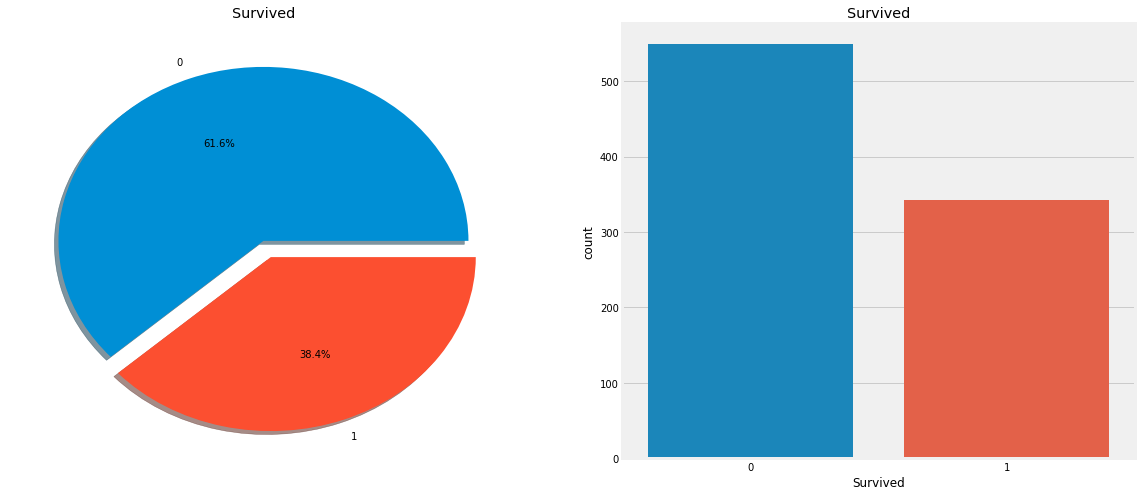

In [3]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=data,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

# Sex--> Categorical Feature

In [78]:
data.groupby(['Sex','Survived'])['Survived'].count()

Sex  Survived
0    0           468
     1           109
1    0            81
     1           233
Name: Survived, dtype: int64

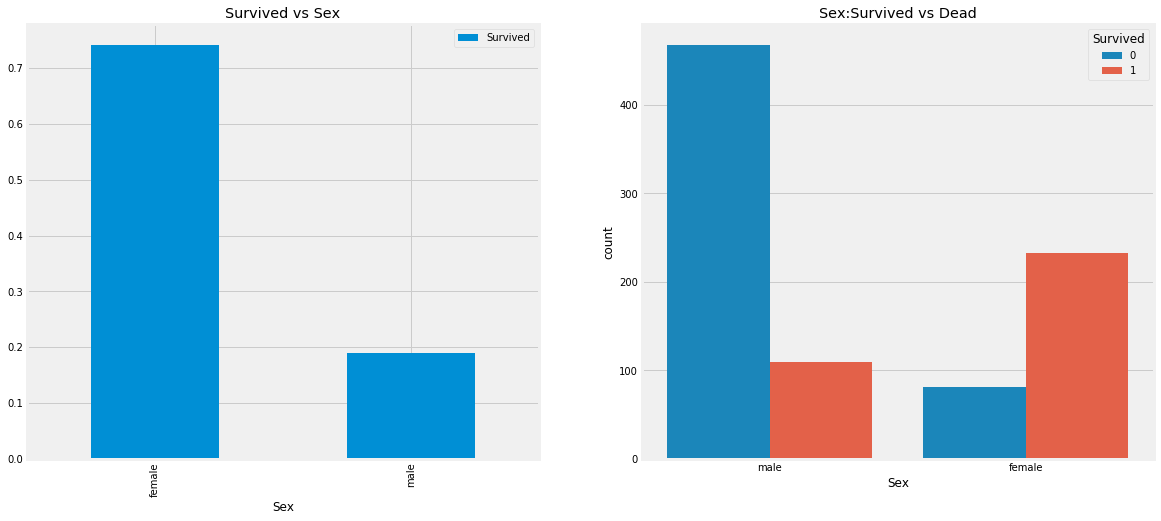

In [5]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

性别数据总结：This looks interesting. The number of men on the ship is lot more than the number of women. 
Still the number of women saved is almost twice the number of males saved. 
The survival rates for a women on the ship is around 75% while that for men in around 18-19%.

This looks to be a very important feature for modeling. But is it the best?? Lets check other features.

# Pclass --> Ordinal Feature

pclass特征分析(pclass 代表船舱等级 1:头等舱，2:二等舱，3：三等舱，间接反映财富和社会地位)。

In [6]:
pd.crosstab(data.Pclass,data.Survived,margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


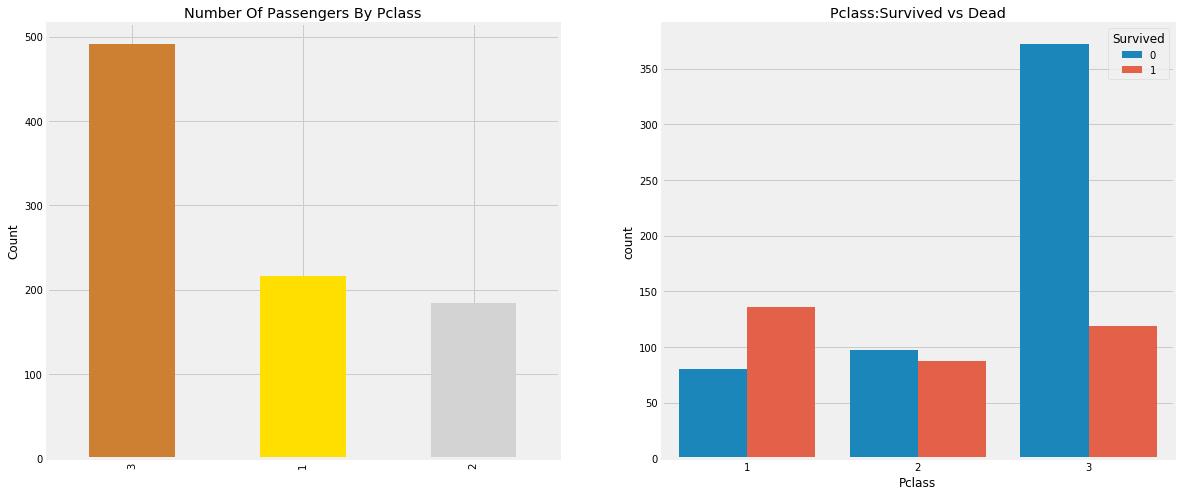

In [7]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot('Pclass',hue='Survived',data=data,ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

People say Money Can't Buy Everything. But we can clearly see that Passenegers Of Pclass 1 were given a very high priority while rescue. Even though the the number of Passengers in Pclass 3 were a lot higher, still the number of survival from them is very low, somewhere around 25%.

For Pclass 1 %survived is around 63% while for Pclass2 is around 48%. So money and status matters. Such a materialistic world.

Lets Dive in little bit more and check for other interesting observations. Lets check survival rate with Sex and Pclass Together.

In [8]:
pd.crosstab([data.Sex,data.Survived],data.Pclass,margins=True).style.background_gradient(cmap='summer_r')

d:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
d:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


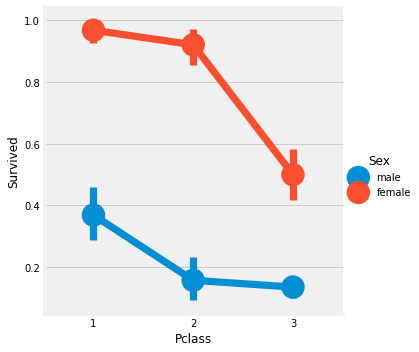

In [9]:
sns.factorplot('Pclass','Survived',hue='Sex',data=data)
plt.show()

We use FactorPlot in this case, because they make the seperation of categorical values easy.

Looking at the CrossTab and the FactorPlot, we can easily infer that survival for Women from Pclass1 is about 95-96%, as only 3 out of 94 Women from Pclass1 died.

It is evident that irrespective of Pclass, Women were given first priority while rescue. Even Men from Pclass1 have a very low survival rate.

Looks like Pclass is also an important feature. Lets analyse other features.

# Age--> Continous Feature

In [10]:
print('Oldest Passenger was of:',data['Age'].max(),'Years')
print('Youngest Passenger was of:',data['Age'].min(),'Years')
print('Average Age on the ship:',data['Age'].mean(),'Years')

Oldest Passenger was of: 80.0 Years
Youngest Passenger was of: 0.42 Years
Average Age on the ship: 29.69911764705882 Years


d:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


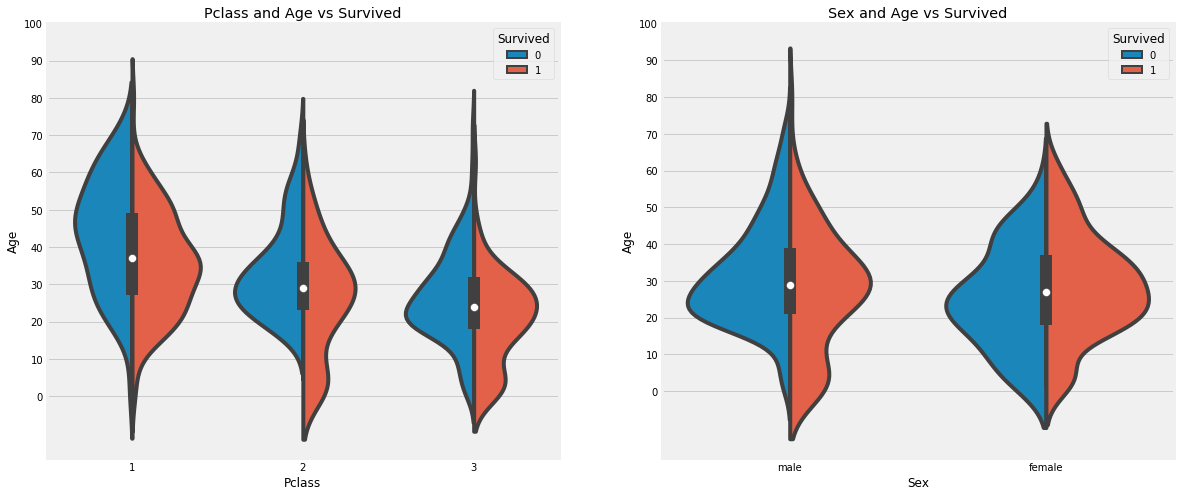

In [11]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age", hue="Survived", data=data,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age", hue="Survived", data=data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

Observations:
1)The number of children increases with Pclass and the survival rate for passenegers below Age 10(i.e children) looks to be good irrespective of the Pclass.

2)Survival chances for Passenegers aged 20-50 from Pclass1 is high and is even better for Women.

3)For males, the survival chances decreases with an increase in age.

As we had seen earlier, the Age feature has 177 null values. To replace these NaN values, we can assign them the mean age of the dataset.

But the problem is, there were many people with many different ages. We just cant assign a 4 year kid with the mean age that is 29 years. Is there any way to find out what age-band does the passenger lie??

Bingo!!!!, we can check the Name feature. Looking upon the feature, we can see that the names have a salutation like Mr or Mrs. Thus we can assign the mean values of Mr and Mrs to the respective groups.

''What's In A Name??''---> Feature :p

In [12]:
data['Initial']=0
for i in data:
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

Okay so here we are using the Regex: [A-Za-z]+).. So what it does is, it looks for strings which lie between A-Z or a-z and followed by a .(dot). So we successfully extract the Initials from the Name.

In [13]:
pd.crosstab(data.Initial,data.Sex).T.style.background_gradient(cmap='summer_r') #Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [14]:
data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [15]:
data.groupby('Initial')['Age'].mean() #lets check the average age by Initials

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

In [16]:
## Assigning the NaN Values with the Ceil values of the mean ages
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

In [17]:
data.Age.isnull().any()

False

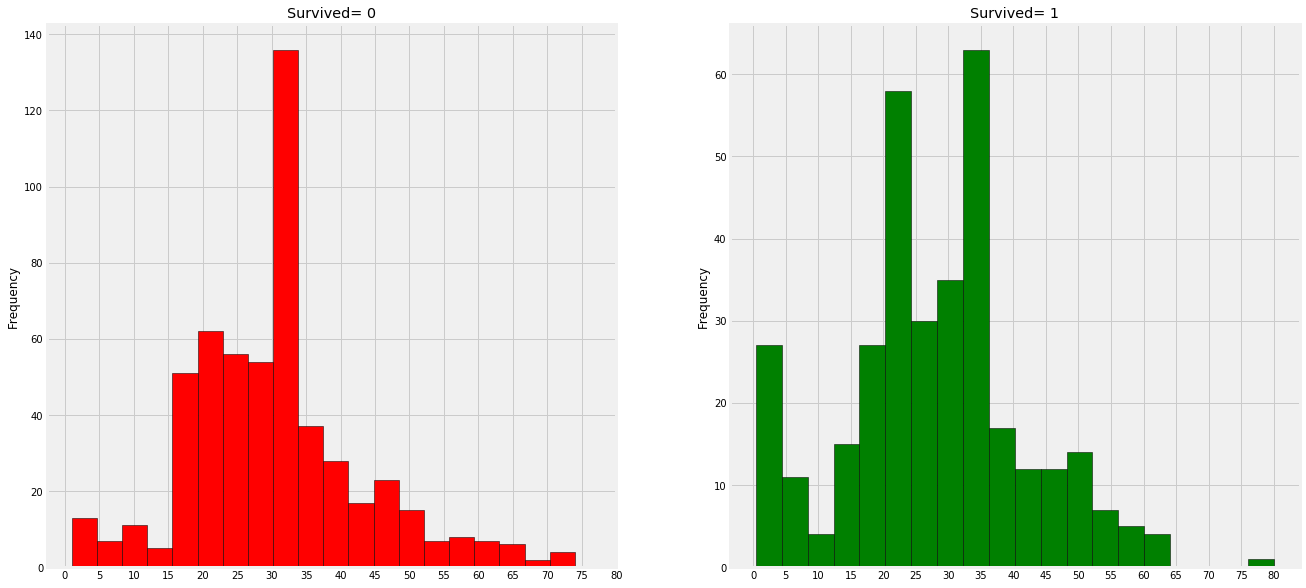

In [18]:
f,ax=plt.subplots(1,2,figsize=(20,10))
data[data['Survived']==0].Age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('Survived= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
data[data['Survived']==1].Age.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('Survived= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

Observations:
1)The Toddlers(age<5) were saved in large numbers(The Women and Child First Policy).

2)The oldest Passenger was saved(80 years).

3)Maximum number of deaths were in the age group of 30-40.

d:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
d:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


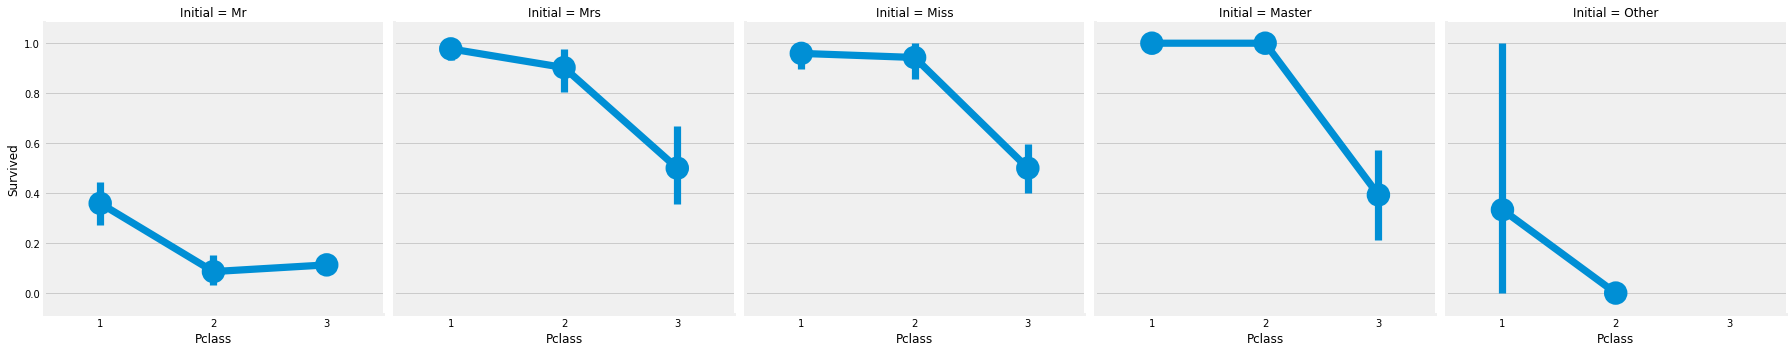

In [19]:
sns.factorplot('Pclass','Survived',col='Initial',data=data)
plt.show()

The Women and Child first policy thus holds true irrespective of the class.

In [20]:
pd.crosstab([data.Embarked,data.Pclass],[data.Sex,data.Survived],margins=True).style.background_gradient(cmap='summer_r')

d:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
d:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


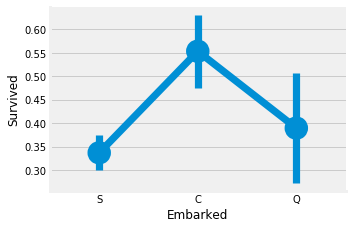

In [21]:
sns.factorplot('Embarked','Survived',data=data)
fig=plt.gcf()
fig.set_size_inches(5,3)
plt.show()

The chances for survival for Port C is highest around 0.55 while it is lowest for S.

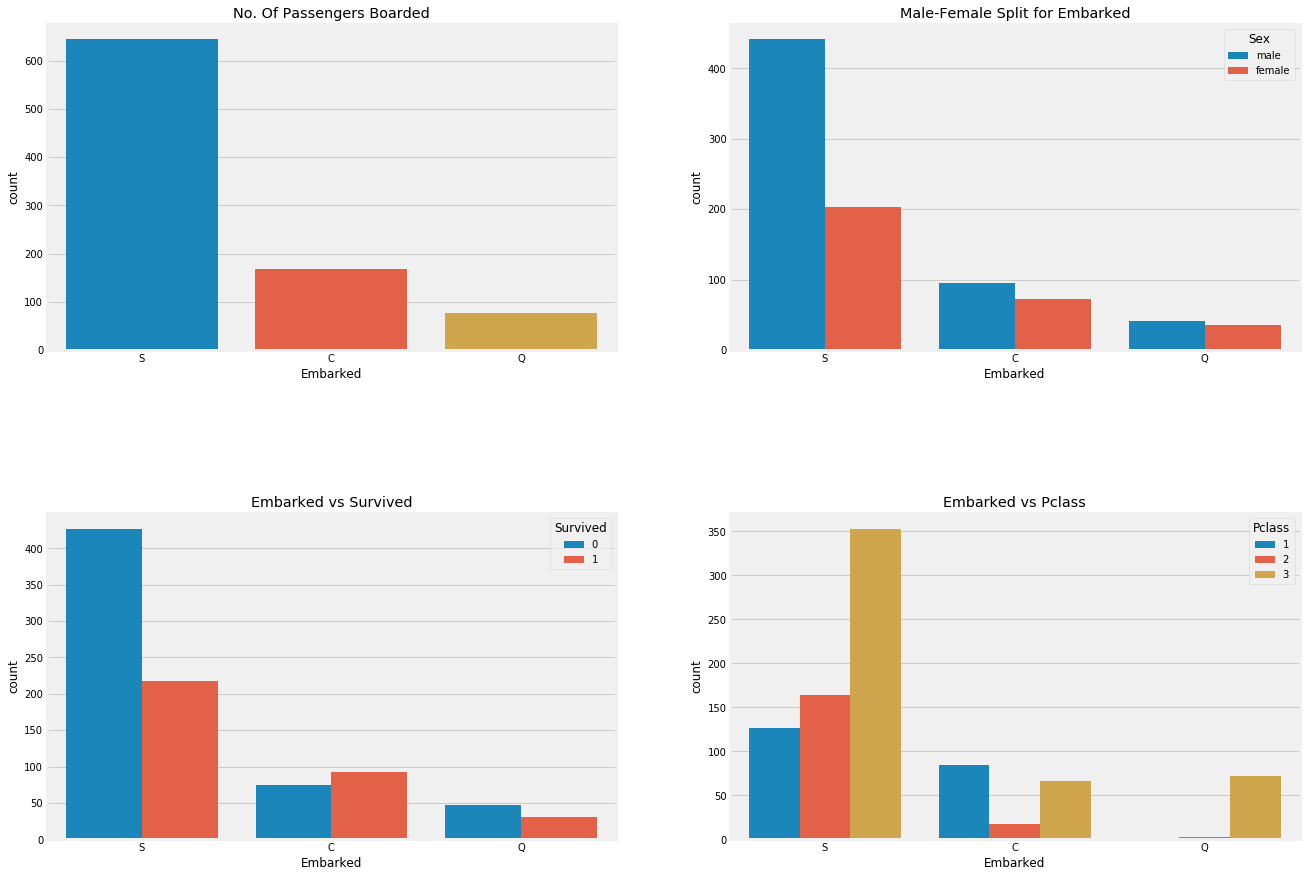

In [22]:
f,ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot('Embarked',data=data,ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')
sns.countplot('Embarked',hue='Sex',data=data,ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')
sns.countplot('Embarked',hue='Survived',data=data,ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
sns.countplot('Embarked',hue='Pclass',data=data,ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

Observations:
1)Maximum passenegers boarded from S. Majority of them being from Pclass3.

2)The Passengers from C look to be lucky as a good proportion of them survived. The reason for this maybe the rescue of all the Pclass1 and Pclass2 Passengers.

3)The Embark S looks to the port from where majority of the rich people boarded. Still the chances for survival is low here, that is because many passengers from Pclass3 around 81% didn't survive.

4)Port Q had almost 95% of the passengers were from Pclass3.

d:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
d:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


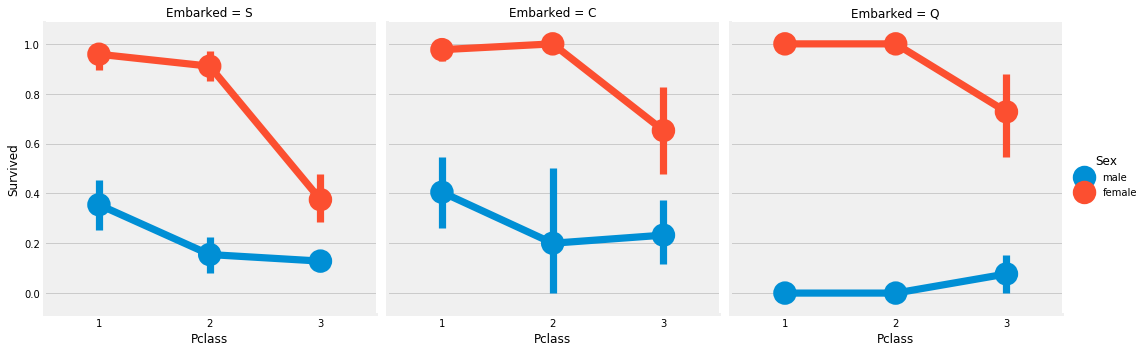

In [23]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=data)
plt.show()

Observations:
1)The survival chances are almost 1 for women for Pclass1 and Pclass2 irrespective of the Pclass.

2)Port S looks to be very unlucky for Pclass3 Passenegers as the survival rate for both men and women is very low.(Money Matters)

3)Port Q looks looks to be unlukiest for Men, as almost all were from Pclass 3.

Filling Embarked NaN
As we saw that maximum passengers boarded from Port S, we replace NaN with S.

In [24]:
data['Embarked'].fillna('S',inplace=True)

In [25]:
data.Embarked.isnull().any()# Finally No NaN values

False

# SibSip-->Discrete Feature

This feature represents whether a person is alone or with his family members.

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife

In [26]:
pd.crosstab([data.SibSp],data.Survived).style.background_gradient(cmap='summer_r')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


d:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
d:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


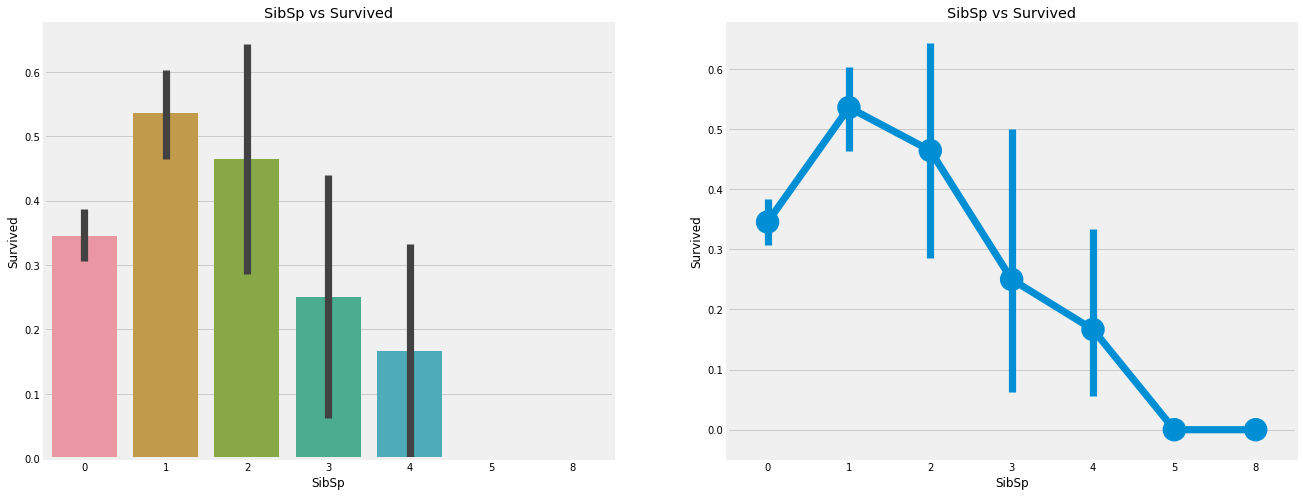

In [27]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('SibSp','Survived',data=data,ax=ax[0])
ax[0].set_title('SibSp vs Survived')
sns.factorplot('SibSp','Survived',data=data,ax=ax[1])
ax[1].set_title('SibSp vs Survived')
plt.close(2)
plt.show()

In [28]:
pd.crosstab(data.SibSp,data.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


Observations:
The barplot and factorplot shows that if a passenger is alone onboard with no siblings, he have 34.5% survival rate. The graph roughly decreases if the number of siblings increase. This makes sense. That is, if I have a family on board, I will try to save them instead of saving myself first. Surprisingly the survival for families with 5-8 members is 0%. The reason may be Pclass??

The reason is Pclass. The crosstab shows that Person with SibSp>3 were all in Pclass3. It is imminent that all the large families in Pclass3(>3) died.

Parch

In [29]:
pd.crosstab(data.Parch,data.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


The crosstab again shows that larger families were in Pclass3.

d:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
d:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


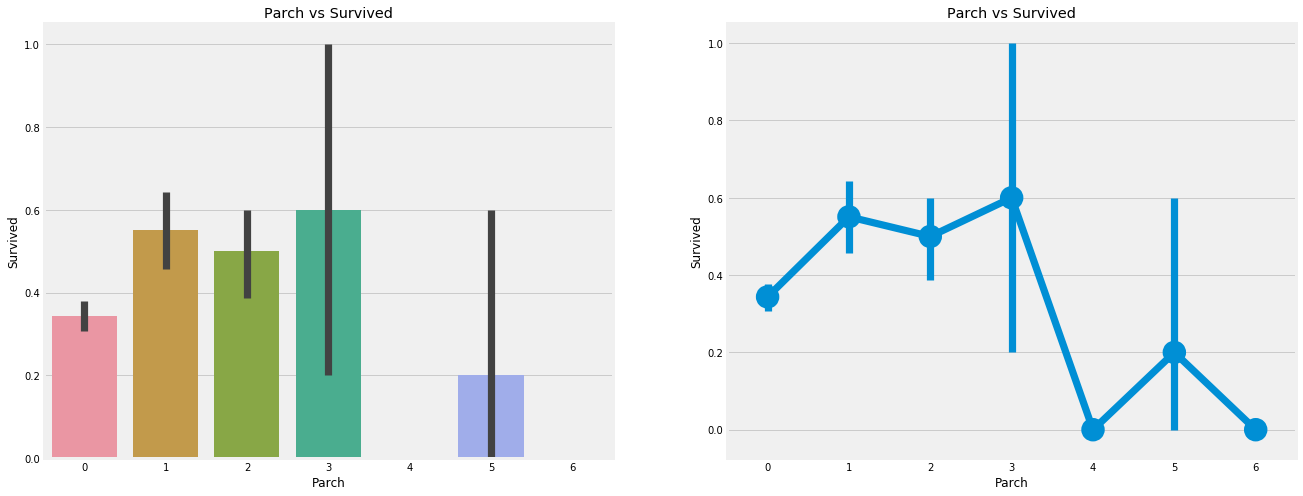

In [30]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('Parch','Survived',data=data,ax=ax[0])
ax[0].set_title('Parch vs Survived')
sns.factorplot('Parch','Survived',data=data,ax=ax[1])
ax[1].set_title('Parch vs Survived')
plt.close(2)
plt.show()

Observations:
Here too the results are quite similar. Passengers with their parents onboard have greater chance of survival. It however reduces as the number goes up.

The chances of survival is good for somebody who has 1-3 parents on the ship. Being alone also proves to be fatal and the chances for survival decreases when somebody has >4 parents on the ship.

Fare--> Continous Feature

In [31]:
print('Highest Fare was:',data['Fare'].max())
print('Lowest Fare was:',data['Fare'].min())
print('Average Fare was:',data['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.2042079685746


d:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


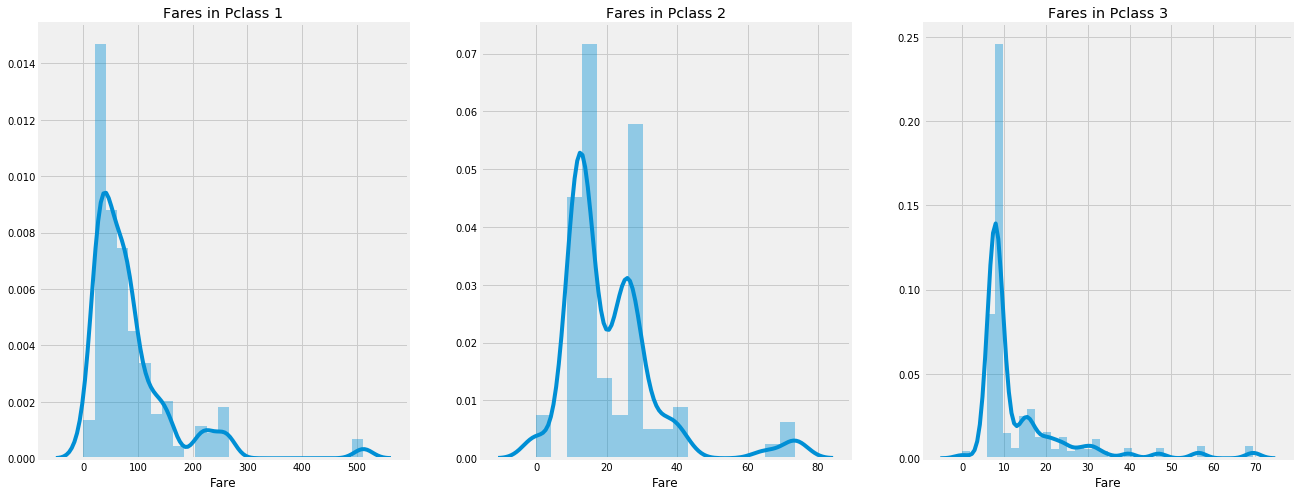

In [32]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(data[data['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(data[data['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(data[data['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

There looks to be a large distribution in the fares of Passengers in Pclass1 and this distribution goes on decreasing as the standards reduces. As this is also continous, we can convert into discrete values by using binning.

# Observations in a Nutshell for all features:

Sex: The chance of survival for women is high as compared to men.

Pclass:There is a visible trend that being a 1st class passenger gives you better chances of survival. The survival rate for Pclass3 is very low. For women, the chance of survival from Pclass1 is almost 1 and is high too for those from Pclass2. Money Wins!!!.

Age: Children less than 5-10 years do have a high chance of survival. Passengers between age group 15 to 35 died a lot.

Embarked: This is a very interesting feature. The chances of survival at C looks to be better than even though the majority of Pclass1 passengers got up at S. Passengers at Q were all from Pclass3.

Parch+SibSp: Having 1-2 siblings,spouse on board or 1-3 Parents shows a greater chance of probablity rather than being alone or having a large family travelling with you.

# Correlation Between The Features

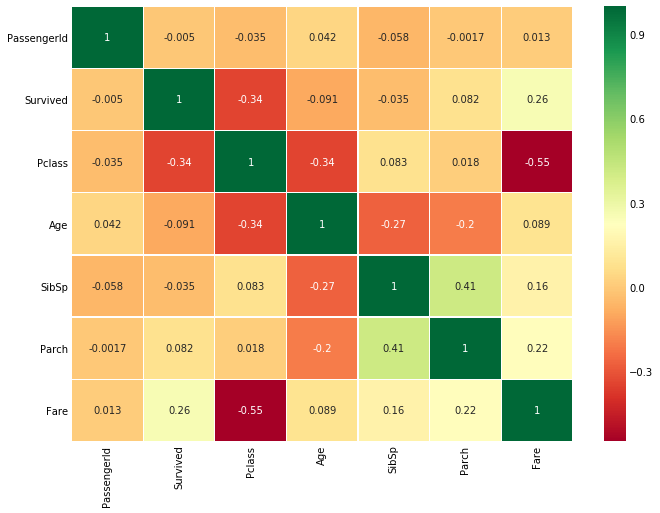

In [33]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

nterpreting The Heatmap
The first thing to note is that only the numeric features are compared as it is obvious that we cannot correlate between alphabets or strings. Before understanding the plot, let us see what exactly correlation is.

POSITIVE CORRELATION: If an increase in feature A leads to increase in feature B, then they are positively correlated. A value 1 means perfect positive correlation.

NEGATIVE CORRELATION: If an increase in feature A leads to decrease in feature B, then they are negatively correlated. A value -1 means perfect negative correlation.

Now lets say that two features are highly or perfectly correlated, so the increase in one leads to increase in the other. This means that both the features are containing highly similar information and there is very little or no variance in information. This is known as MultiColinearity as both of them contains almost the same information.

So do you think we should use both of them as one of them is redundant. While making or training models, we should try to eliminate redundant features as it reduces training time and many such advantages.

Now from the above heatmap,we can see that the features are not much correlated. The highest correlation is between SibSp and Parch i.e 0.41. So we can carry on with all features.

# Part2: Feature Engineering and Data Cleaning

Now what is Feature Engineering?

Whenever we are given a dataset with features, it is not necessary that all the features will be important. There maybe be many redundant features which should be eliminated. Also we can get or add new features by observing or extracting information from other features.

An example would be getting the Initals feature using the Name Feature. Lets see if we can get any new features and eliminate a few. Also we will tranform the existing relevant features to suitable form for Predictive Modeling.

# Age_band

Problem With Age Feature:
As I have mentioned earlier that Age is a continous feature, there is a problem with Continous Variables in Machine Learning Models.

Eg:If I say to group or arrange Sports Person by Sex, We can easily segregate them by Male and Female.

Now if I say to group them by their Age, then how would you do it? If there are 30 Persons, there may be 30 age values. Now this is problematic.

We need to convert these continous values into categorical values by either Binning or Normalisation. I will be using binning i.e group a range of ages into a single bin or assign them a single value.

Okay so the maximum age of a passenger was 80. So lets divide the range from 0-80 into 5 bins. So 80/5=16. So bins of size 16.

In [34]:
data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


In [35]:
data['Age_band'].value_counts().to_frame().style.background_gradient(cmap='summer')#checking the number of passenegers in each band

,Age_band
1,382
2,325
0,104
3,69
4,11


d:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
d:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


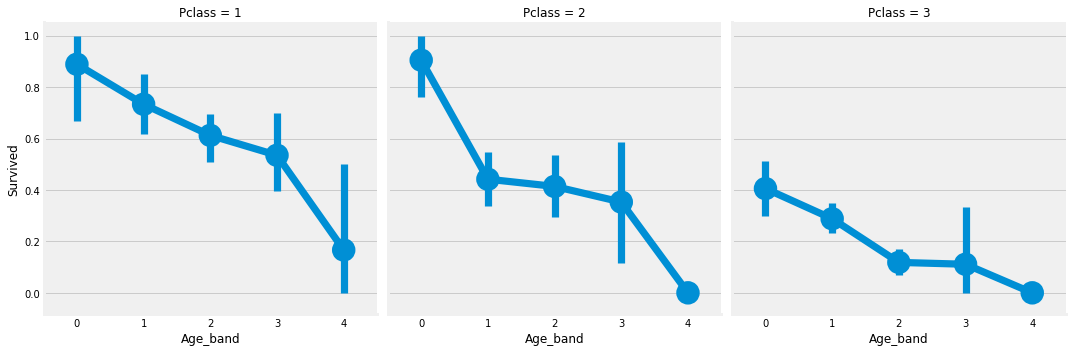

In [36]:
sns.factorplot('Age_band','Survived',data=data,col='Pclass')
plt.show()

True that..the survival rate decreases as the age increases irrespective of the Pclass.

# Family_Size and Alone

At this point, we can create a new feature called "Family_size" and "Alone" and analyse it. This feature is the summation of Parch and SibSp. It gives us a combined data so that we can check if survival rate have anything to do with family size of the passengers. Alone will denote whether a passenger is alone or not.

d:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
d:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
d:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` i

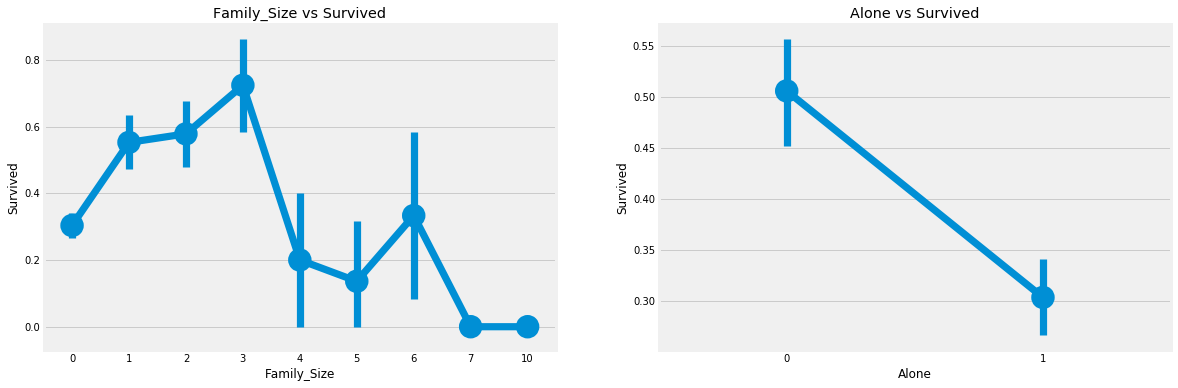

In [37]:
data['Family_Size']=0
data['Family_Size']=data['Parch']+data['SibSp']#family size
data['Alone']=0
data.loc[data.Family_Size==0,'Alone']=1#Alone

f,ax=plt.subplots(1,2,figsize=(18,6))
sns.factorplot('Family_Size','Survived',data=data,ax=ax[0])
ax[0].set_title('Family_Size vs Survived')
sns.factorplot('Alone','Survived',data=data,ax=ax[1])
ax[1].set_title('Alone vs Survived')
plt.close(2)
plt.close(3)
plt.show()

Family_Size=0 means that the passeneger is alone. Clearly, if you are alone or family_size=0,then chances for survival is very low. For family size > 4,the chances decrease too. This also looks to be an important feature for the model. Lets examine this further.

d:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
d:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


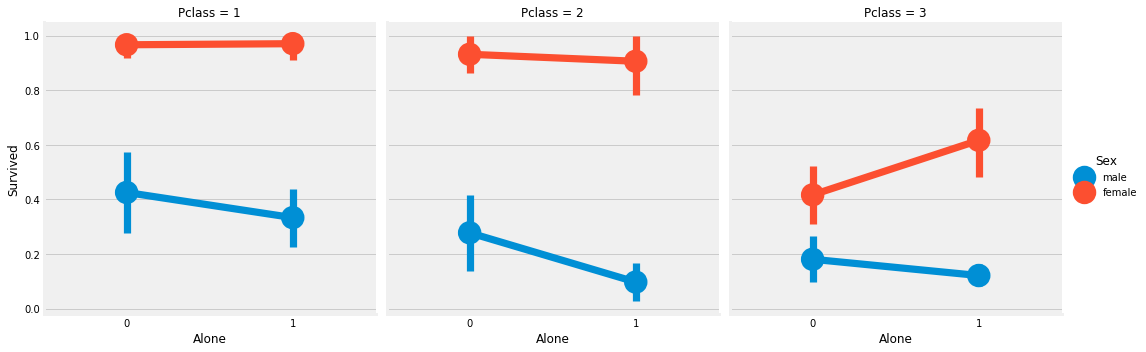

In [38]:
sns.factorplot('Alone','Survived',data=data,hue='Sex',col='Pclass')
plt.show()

It is visible that being alone is harmful irrespective of Sex or Pclass except for Pclass3 where the chances of females who are alone is high than those with family.

# Fare_Range

Since fare is also a continous feature, we need to convert it into ordinal value. For this we will use pandas.qcut.

So what qcut does is it splits or arranges the values according the number of bins we have passed. So if we pass for 5 bins, it will arrange the values equally spaced into 5 seperate bins or value ranges.

In [39]:
data['Fare_Range']=pd.qcut(data['Fare'],4)
data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


As discussed above, we can clearly see that as the fare_range increases, the chances of survival increases.

Now we cannot pass the Fare_Range values as it is. We should convert it into singleton values same as we did in Age_Band

In [40]:
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

d:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
d:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


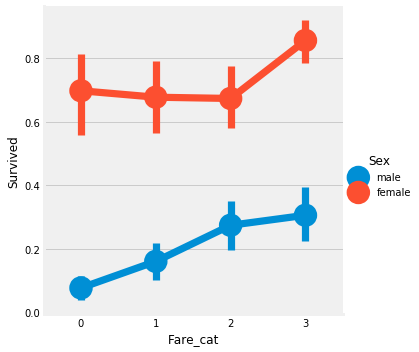

In [41]:
sns.factorplot('Fare_cat','Survived',data=data,hue='Sex')
plt.show()

Clearly, as the Fare_cat increases, the survival chances increases. This feature may become an important feature during modeling along with the Sex.

# Converting String Values into Numeric

Since we cannot pass strings to a machine learning model, we need to convert features loke Sex, Embarked, etc into numeric values.

In [42]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

Dropping UnNeeded Features
Name--> We don't need name feature as it cannot be converted into any categorical value.

Age--> We have the Age_band feature, so no need of this.

Ticket--> It is any random string that cannot be categorised.

Fare--> We have the Fare_cat feature, so unneeded

Cabin--> A lot of NaN values and also many passengers have multiple cabins. So this is a useless feature.

Fare_Range--> We have the fare_cat feature.

PassengerId--> Cannot be categorised.

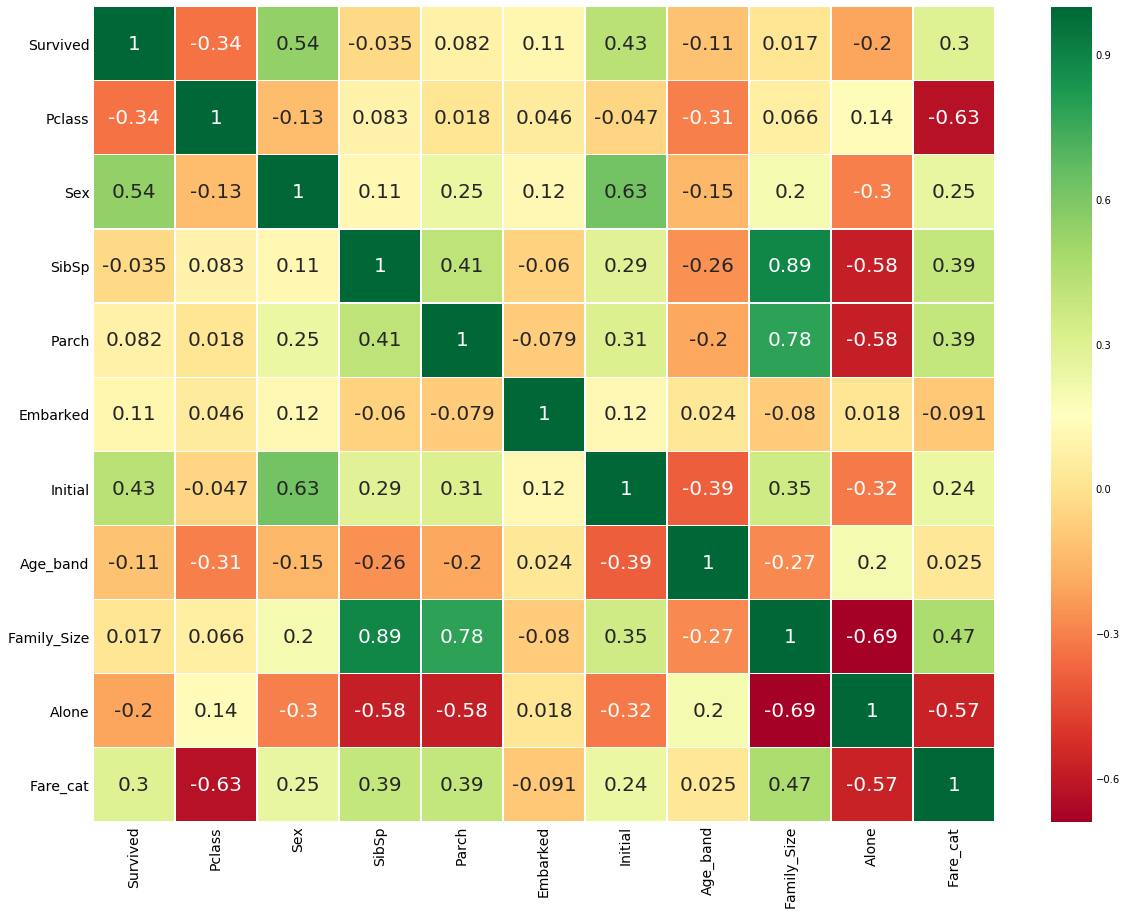

In [43]:
data.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Part3: Predictive Modeling

We have gained some insights from the EDA part. But with that, we cannot accurately predict or tell whether a passenger will survive or die. So now we will predict the whether the Passenger will survive or not using some great Classification Algorithms.Following are the algorithms I will use to make the model:

1)Logistic Regression

2)Support Vector Machines(Linear and radial)

3)Random Forest

4)K-Nearest Neighbours

5)Naive Bayes

6)Decision Tree

7)Logistic Regression

In [44]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [45]:
train,test=train_test_split(data,test_size=0.3,random_state=0,stratify=data['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=data[data.columns[1:]]
Y=data['Survived']

# Radial Support Vector Machines(rbf-SVM)

In [46]:
model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X,train_Y.values.ravel())
prediction1=model.predict(test_X)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,test_Y))

Accuracy for rbf SVM is  0.835820895522388


# Linear Support Vector Machine(linear-SVM)

In [47]:
model=svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model.fit(train_X,train_Y.values.ravel())
prediction2=model.predict(test_X)
print('Accuracy for linear SVM is',metrics.accuracy_score(prediction2,test_Y))

Accuracy for linear SVM is 0.8171641791044776


# Logistic Regression

In [48]:
model = LogisticRegression()
model.fit(train_X,train_Y.values.ravel())
prediction3=model.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,test_Y))

The accuracy of the Logistic Regression is 0.8171641791044776


# Decision Tree

In [49]:
model=DecisionTreeClassifier()
model.fit(train_X,train_Y)
prediction4=model.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_Y))

The accuracy of the Decision Tree is 0.8059701492537313


# K-Nearest Neighbours(KNN)

In [50]:
model=KNeighborsClassifier() 
model.fit(train_X,train_Y.values.ravel())
prediction5=model.predict(test_X)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction5,test_Y))

The accuracy of the KNN is 0.832089552238806


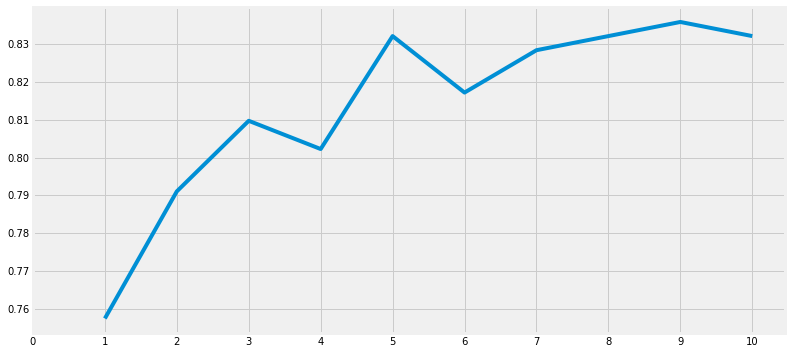

Accuracies for different values of n are: [0.75746269 0.79104478 0.80970149 0.80223881 0.83208955 0.81716418
 0.82835821 0.83208955 0.8358209  0.83208955] with the max value as  0.835820895522388


In [51]:
a_index=list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(train_X,train_Y.values.ravel())
    prediction=model.predict(test_X)
    a=a.append(pd.Series(metrics.accuracy_score(prediction,test_Y)))
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a.values,'with the max value as ',a.values.max())

# Gaussian Naive Bayes

In [52]:
model=GaussianNB()
model.fit(train_X,train_Y.values.ravel())
prediction6=model.predict(test_X)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction6,test_Y))

The accuracy of the NaiveBayes is 0.8134328358208955


# Random Forests

In [53]:
model=RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y.values.ravel())
prediction7=model.predict(test_X)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,test_Y))

The accuracy of the Random Forests is 0.8171641791044776


The accuracy of a model is not the only factor that determines the robustness of the classifier. Let's say that a classifier is trained over a training data and tested over the test data and it scores an accuracy of 90%.

Now this seems to be very good accuracy for a classifier, but can we confirm that it will be 90% for all the new test sets that come over??. The answer is No, because we can't determine which all instances will the classifier will use to train itself. As the training and testing data changes, the accuracy will also change. It may increase or decrease. This is known as model variance.

To overcome this and get a generalized model,we use Cross Validation.

# Cross Validation

Many a times, the data is imbalanced, i.e there may be a high number of class1 instances but less number of other class instances. Thus we should train and test our algorithm on each and every instance of the dataset. Then we can take an average of all the noted accuracies over the dataset.

1)The K-Fold Cross Validation works by first dividing the dataset into k-subsets.

2)Let's say we divide the dataset into (k=5) parts. We reserve 1 part for testing and train the algorithm over the 4 parts.

3)We continue the process by changing the testing part in each iteration and training the algorithm over the other parts. The accuracies and errors are then averaged to get a average accuracy of the algorithm.

This is called K-Fold Cross Validation.

4)An algorithm may underfit over a dataset for some training data and sometimes also overfit the data for other training set. Thus with cross-validation, we can achieve a generalised model.

In [54]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

,CV Mean,Std
Linear Svm,0.793471,0.047797
Radial Svm,0.828290,0.034427
Logistic Regression,0.805843,0.021861
KNN,0.813783,0.041210
Decision Tree,0.806991,0.028067
Naive Bayes,0.801386,0.028999
Random Forest,0.811486,0.034489


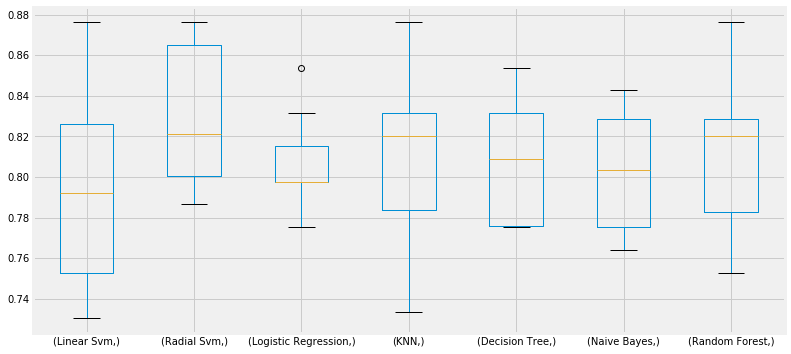

In [55]:
plt.subplots(figsize=(12,6))
box=pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot()

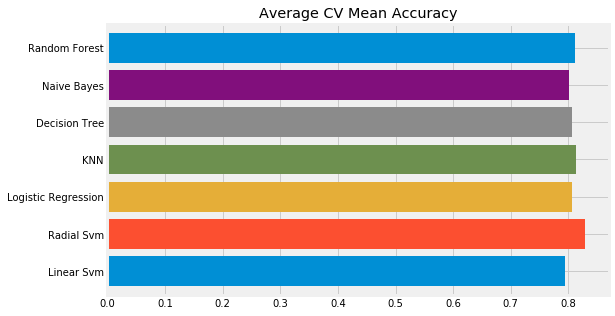

In [56]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

The classification accuracy can be sometimes misleading due to imbalance. We can get a summarized result with the help of confusion matrix, which shows where did the model go wrong, or which class did the model predict wrong.

# Confusion Matrix

It gives the number of correct and incorrect classifications made by the classifier.

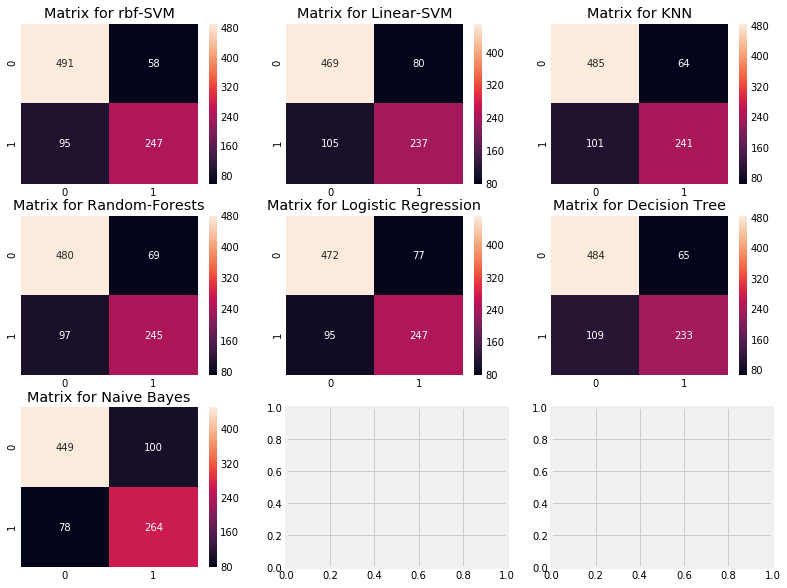

In [57]:
f,ax=plt.subplots(3,3,figsize=(12,10))
y_pred = cross_val_predict(svm.SVC(kernel='rbf'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')
y_pred = cross_val_predict(svm.SVC(kernel='linear'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')
y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')
y_pred = cross_val_predict(LogisticRegression(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')
y_pred = cross_val_predict(DecisionTreeClassifier(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')
y_pred = cross_val_predict(GaussianNB(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

Interpreting Confusion Matrix
The left diagonal shows the number of correct predictions made for each class while the right diagonal shows the number of wrong prredictions made. Lets consider the first plot for rbf-SVM:

1)The no. of correct predictions are 491(for dead) + 247(for survived) with the mean CV accuracy being (491+247)/891 = 82.8% which we did get earlier.

2)Errors--> Wrongly Classified 58 dead people as survived and 95 survived as dead. Thus it has made more mistakes by predicting dead as survived.

By looking at all the matrices, we can say that rbf-SVM has a higher chance in correctly predicting dead passengers but NaiveBayes has a higher chance in correctly predicting passengers who survived.

# Hyper-Parameters Tuning

The machine learning models are like a Black-Box. There are some default parameter values for this Black-Box, which we can tune or change to get a better model. Like the C and gamma in the SVM model and similarly different parameters for different classifiers, are called the hyper-parameters, which we can tune to change the learning rate of the algorithm and get a better model. This is known as Hyper-Parameter Tuning.

We will tune the hyper-parameters for the 2 best classifiers i.e the SVM and RandomForests.

# SVM

In [58]:
from sklearn.model_selection import GridSearchCV
C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kernel=['rbf','linear']
hyper={'kernel':kernel,'C':C,'gamma':gamma}
gd=GridSearchCV(estimator=svm.SVC(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
0.8282828282828283
SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:   11.8s finished


# Random Forests

In [59]:
n_estimators=range(100,1000,100)
hyper={'n_estimators':n_estimators}
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   19.4s finished


0.8170594837261503
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


# Ensembling

Ensembling is a good way to increase the accuracy or performance of a model. In simple words, it is the combination of various simple models to create a single powerful model.

Lets say we want to buy a phone and ask many people about it based on various parameters. So then we can make a strong judgement about a single product after analysing all different parameters. This is Ensembling, which improves the stability of the model. Ensembling can be done in ways like:

1)Voting Classifier

2)Bagging

3)Boosting.

# Voting Classifier

It is the simplest way of combining predictions from many different simple machine learning models. It gives an average prediction result based on the prediction of all the submodels. The submodels or the basemodels are all of diiferent types.

In [60]:
from sklearn.ensemble import VotingClassifier
ensemble_lin_rbf=VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                              ('RBF',svm.SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
                                              ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                              ('LR',LogisticRegression(C=0.05)),
                                              ('DT',DecisionTreeClassifier(random_state=0)),
                                              ('NB',GaussianNB()),
                                              ('svm',svm.SVC(kernel='linear',probability=True))
                                             ], 
                       voting='soft').fit(train_X,train_Y.values.ravel())
print('The accuracy for ensembled model is:',ensemble_lin_rbf.score(test_X,test_Y))
cross=cross_val_score(ensemble_lin_rbf,X,Y, cv = 10,scoring = "accuracy")
print('The cross validated score is',cross.mean())

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The accuracy for ensembled model is: 0.8246268656716418


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

The cross validated score is 0.8237660310974917


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Bagging

Bagging is a general ensemble method. It works by applying similar classifiers on small partitions of the dataset and then taking the average of all the predictions. Due to the averaging,there is reduction in variance. Unlike Voting Classifier, Bagging makes use of similar classifiers.

Bagged KNN
Bagging works best with models with high variance. An example for this can be Decision Tree or Random Forests. We can use KNN with small value of n_neighbours, as small value of n_neighbours.

In [61]:
from sklearn.ensemble import BaggingClassifier
model=BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),random_state=0,n_estimators=700)
model.fit(train_X,train_Y.values.ravel())
prediction=model.predict(test_X)
print('The accuracy for bagged KNN is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged KNN is:',result.mean())

The accuracy for bagged KNN is: 0.835820895522388
The cross validated score for bagged KNN is: 0.8148893428668709


# Bagged DecisionTree

In [62]:
model=BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=0,n_estimators=100)
model.fit(train_X,train_Y.values.ravel())
prediction=model.predict(test_X)
print('The accuracy for bagged Decision Tree is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged Decision Tree is:',result.mean())

The accuracy for bagged Decision Tree is: 0.8246268656716418
The cross validated score for bagged Decision Tree is: 0.8204826353421859


# Boosting

Boosting is an ensembling technique which uses sequential learning of classifiers. It is a step by step enhancement of a weak model.Boosting works as follows:

A model is first trained on the complete dataset. Now the model will get some instances right while some wrong. Now in the next iteration, the learner will focus more on the wrongly predicted instances or give more weight to it. Thus it will try to predict the wrong instance correctly. Now this iterative process continous, and new classifers are added to the model until the limit is reached on the accuracy.

AdaBoost(Adaptive Boosting)
The weak learner or estimator in this case is a Decsion Tree. But we can change the dafault base_estimator to any algorithm of our choice.

In [63]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
result=cross_val_score(ada,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoost is:',result.mean())

The cross validated score for AdaBoost is: 0.8249526160481218


Stochastic Gradient Boosting

Here too the weak learner is a Decision Tree.

In [64]:
from sklearn.ensemble import GradientBoostingClassifier
grad=GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
result=cross_val_score(grad,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for Gradient Boosting is:',result.mean())

The cross validated score for Gradient Boosting is: 0.8182862331176939


# XGBoost

In [65]:
import xgboost as xg
xgboost=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
result=cross_val_score(xgboost,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for XGBoost is:',result.mean())

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

The cross validated score for XGBoost is: 0.8104710021563954


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


We got the highest accuracy for AdaBoost. We will try to increase it with Hyper-Parameter Tuning

# Hyper-Parameter Tuning for AdaBoost

In [66]:
n_estimators=list(range(100,1100,100))
learn_rate=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
hyper={'n_estimators':n_estimators,'learning_rate':learn_rate}
gd=GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  5.5min finished


0.8316498316498316
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.05, n_estimators=200, random_state=None)


# Confusion Matrix for the Best Model

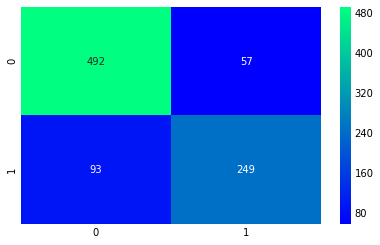

In [70]:
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.05)
result=cross_val_predict(ada,X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,result),cmap='winter',annot=True,fmt='2.0f')
plt.show()

# Feature Importance

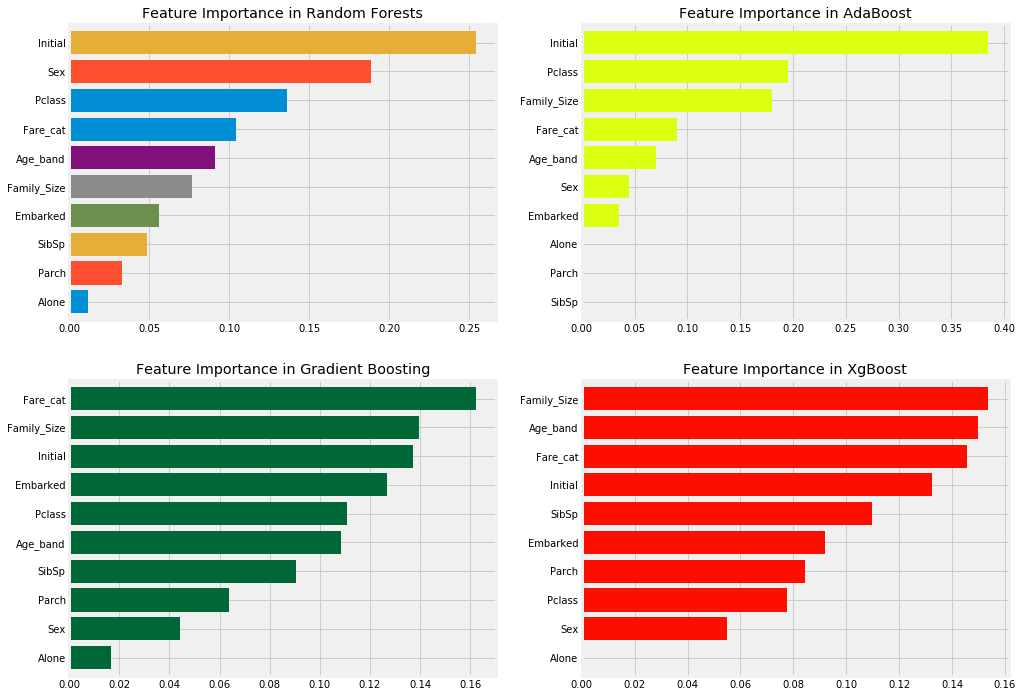

In [75]:
f,ax=plt.subplots(2,2,figsize=(15,12))
model=RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')
model=AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in AdaBoost')
model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')
model=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')
plt.show()

We can see the important features for various classifiers like RandomForests, AdaBoost,etc.

# Observations:

1)Some of the common important features are Initial,Fare_cat,Pclass,Family_Size.

2)The Sex feature doesn't seem to give any importance, which is shocking as we had seen earlier that Sex combined with Pclass was giving a very good differentiating factor. Sex looks to be important only in RandomForests.

However, we can see the feature Initial, which is at the top in many classifiers.We had already seen the positive correlation between Sex and Initial, so they both refer to the gender.

3)Similarly the Pclass and Fare_cat refer to the status of the passengers and Family_Size with Alone,Parch and SibSp.